In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
data=pd.read_csv('BTCUSD.csv')
data['Date'] = pd.to_datetime(data['Date'])
data_train=data[data['Date'].dt.year.isin([2020,2021,2022])]
data_2023=data[data['Date'].dt.year == 2023]

In [3]:
train=data_train['Close'].values
test=data_2023['Close'].values

In [4]:
from sklearn.preprocessing import MinMaxScaler
in_scaler=MinMaxScaler(feature_range=(-1,1))
train=in_scaler.fit_transform(train.reshape(-1,1))
test=in_scaler.transform(test.reshape(-1,1))

In [5]:
ws=9 # windows size
def data_loader(train, test,window_size,output_window_size):
    train_seq=[]
    train_tar=[]
    test_seq=[]
    test_tar=[]
    
    for i in range(len(train)-window_size):
        train_seq.append(train[i:i+window_size])
        train_tar.append(train[i+window_size:i+ws+output_window_size])
    for i in range(len(test)-window_size):
        test_seq.append(test[i:i+window_size])
        test_tar.append(test[i+window_size:i+window_size+output_window_size])
    return [train_seq, train_tar, test_seq, test_tar]

train_seq,train_tar, test_seq, test_tar=data_loader(train, test,ws,1)

In [6]:
train_seq=torch.Tensor(np.array(train_seq))
train_tar=torch.Tensor(np.array(train_tar))
test_seq=torch.Tensor(np.array(test_seq))
test_tar=torch.Tensor(np.array(test_tar))
train_tar=train_tar.squeeze(-1)
test_tar=train_tar.squeeze(-1)

In [7]:
train_seq.shape, train_tar.shape,test_seq.shape,test_tar.shape

(torch.Size([1087, 9, 1]),
 torch.Size([1087, 1]),
 torch.Size([356, 9, 1]),
 torch.Size([1087]))

In [8]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_seq=train_seq.to(device)
train_tar=train_tar.to(device)
test_seq=test_seq.to(device)
test_tar=test_tar.to(device)

In [13]:
class Encode(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encode, self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.layer = nn.Sequential(
            nn.Conv1d(input_size,hidden_size,3,1,1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(hidden_size,hidden_size,3,1,1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(hidden_size,1,3,1,1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out = self.layer(x)
        out = out.permute(0, 2, 1)
        return out
    
class Decode(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Decode, self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.layer = nn.Sequential(
            nn.LSTM(input_size,hidden_size, num_layers, batch_first=True),
        )
        self.fc=nn.Linear(hidden_size,output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, (hn, cn)= self.layer(x)
        
        out=self.fc(out[:, -1, :])
        return out
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder=encoder
        self.decoder=decoder
    def forward(self, x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x


In [14]:
input_size=1
hidden_size=64
num_layers=1
output_size=1
encoder=Encode(input_size, hidden_size, num_layers).to(device)
decoder=Decode(input_size, hidden_size, num_layers, output_size).to(device)
model=Seq2Seq(encoder, decoder).to(device)

In [11]:
train_seq=train_seq.permute(0,2,1)
test_seq=test_seq.permute(0,2,1)

In [18]:
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

num_epochs=100
e_loss=[]
for epoch in range(num_epochs):
    model.train()
    outputs=model(train_seq)
    loss=criterion(outputs, train_tar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    e_loss.append(loss.item())
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.2975
Epoch [20/100], Loss: 0.2974
Epoch [30/100], Loss: 0.2974
Epoch [40/100], Loss: 0.2974
Epoch [50/100], Loss: 0.2974
Epoch [60/100], Loss: 0.2974
Epoch [70/100], Loss: 0.2974
Epoch [80/100], Loss: 0.2974
Epoch [90/100], Loss: 0.2974
Epoch [100/100], Loss: 0.2974


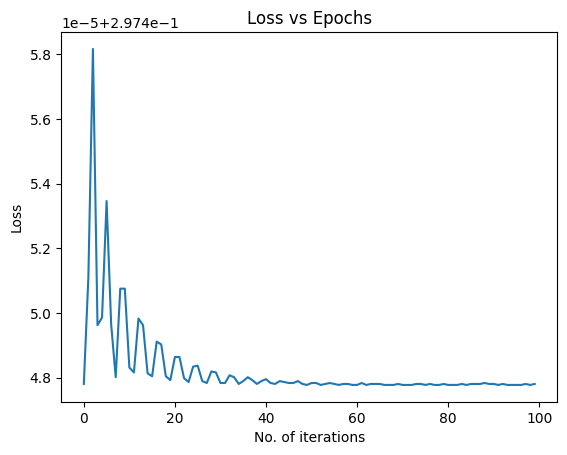

In [19]:
x=range(num_epochs)
plt.plot(x,e_loss)
plt.xlabel('No. of iterations')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

(356, 1)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

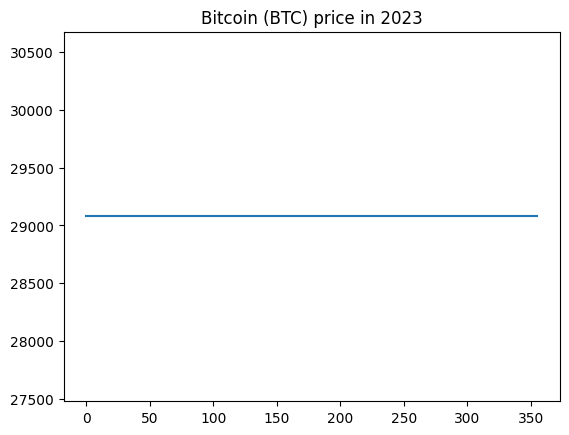

In [21]:
test_pred=model(test_seq).cpu().detach().numpy()
print(test_pred.shape)
test_pred=in_scaler.inverse_transform(test_pred).flatten()



# plotting the predicted prices against the actual prices

plt.title('Bitcoin (BTC) price in 2023')
plt.plot(test_pred, label='Predicted Price')
plt.plot(test_tar, label='Actual Price')
plt.ylabel('Price ')
plt.xlabel('Days ')
plt.legend()
plt.show()